In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/data/groups/jeltema/zhou/lsst_shear/WeakLensingDeblending/bin')
sys.path.append('/data/groups/jeltema/zhou/lsst_shear/WeakLensingDeblending')

In [2]:
import numpy as np
from astropy.io import fits
from astropy.table import Table,vstack
import astropy.table
from tqdm import tqdm,trange
import pickle
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("MNRAS")

In [3]:
from gals_wideblend import *

In [4]:
dc2_path = "../data/dc2_table.fits"
dc2 = Table(fits.open(dc2_path)[1].data)
dc2_df = dc2.to_pandas()

In [5]:
dc2_df.set_index('galtileid',inplace=True)

In [6]:
dc2_df

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass
galtileid,,,,,,,,,,,,,,,,,,,
9687500000,62.584977,-40.334110,16.389235,15.969118,15.751877,15.644171,0.322700,0.677300,0.0,-66.420097,-66.420097,5.632399,2.334110,2.731376,1.998739,0.022012,2.472611e+11,155487,2.266592e+09
9687500001,61.398620,-41.036142,19.776192,19.318966,19.032682,18.882126,0.070049,0.929951,0.0,-59.928261,-59.928261,1.428125,1.384487,0.757303,0.756517,0.020724,5.465768e+10,100155487,2.167333e+07
9687500002,61.024250,-39.783545,17.942350,17.240576,16.882887,16.658743,0.166495,0.833505,0.0,-26.887655,-26.887655,3.075085,2.736342,1.565327,1.546541,0.020339,1.197264e+11,200155487,2.931496e+08
9687500003,61.420014,-39.964448,18.457945,17.741489,17.340651,16.984100,0.331346,0.668654,0.0,-87.747124,-87.747124,4.103955,2.893115,2.159242,2.127429,0.018407,7.027417e+10,300155487,1.110973e+08
9687500004,61.869596,-40.907121,14.888106,14.139737,13.786592,13.539910,0.992869,0.007131,0.0,-94.425529,-94.425529,13.089191,5.745582,6.417689,5.544625,0.021334,1.206931e+13,400155487,2.895573e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8958249412,66.491210,-38.755338,26.147915,25.837452,25.906286,25.985991,0.902513,0.097487,0.0,-58.620407,-58.620407,0.236398,0.158632,0.118805,0.102975,2.998345,1.931316e+11,-57201100143121,7.431215e+08
8958255826,66.537279,-38.458811,26.022764,25.713081,25.772373,25.819675,0.999387,0.000613,0.0,-68.361343,-68.361343,0.377636,0.283932,0.165445,0.158932,3.035001,1.837721e+11,-57842500143121,6.610531e+08
8958269275,65.459549,-38.750976,26.357021,25.871912,26.018427,26.340965,0.020686,0.979314,0.0,-88.874046,-88.874046,0.210473,0.137858,0.120906,0.101252,2.993862,3.047939e+11,-59187400143121,1.815956e+09


Text(0.5, 0, 'Number of galaxies in a halo')

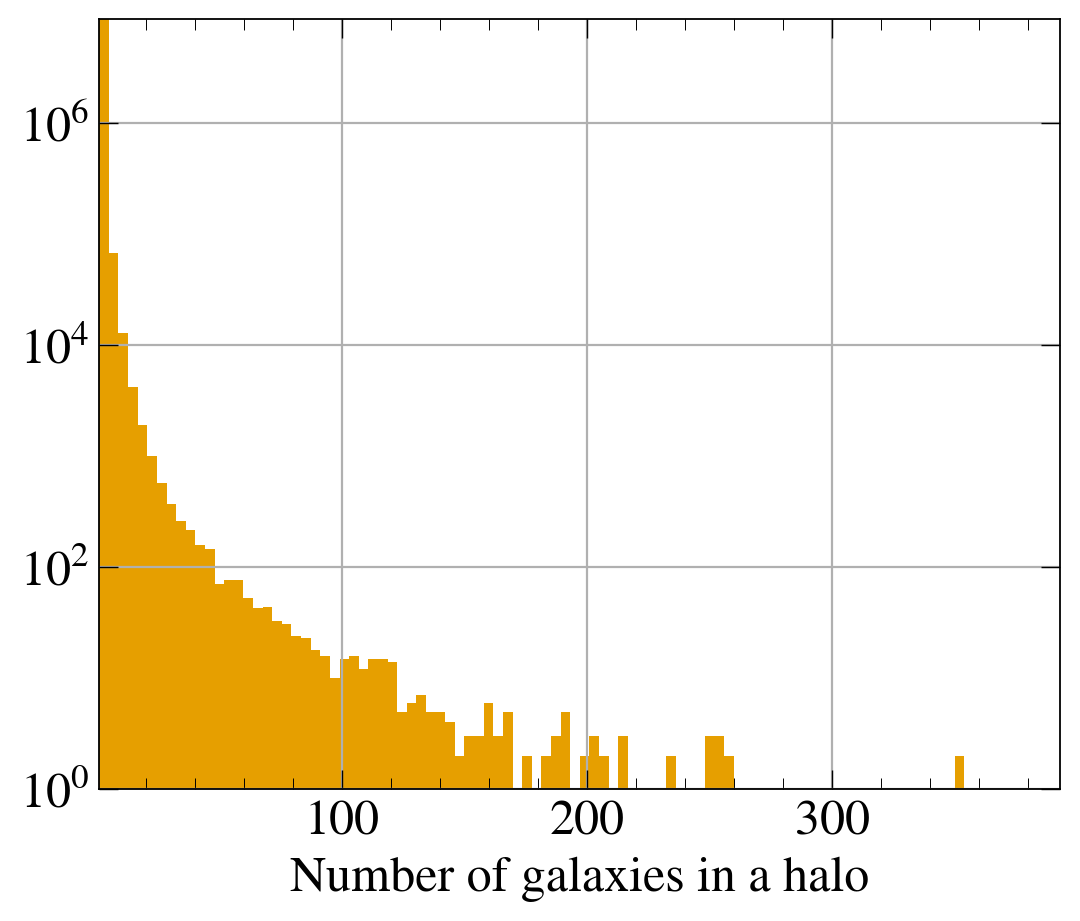

In [7]:
dc2_df.groupby('halo_id').count()['ra'].hist(bins=100,log=True)
plt.xlabel('Number of galaxies in a halo')

In [8]:
dc2_df['log_mass']=np.log10(dc2_df['halo_mass'])

In [9]:
dc2_halo_unique=dc2_df.groupby('halo_id').sample(1,random_state=1)

In [10]:
dc2_halo_unique['log_mass'] = np.log10(dc2_halo_unique['halo_mass'])

<AxesSubplot: >

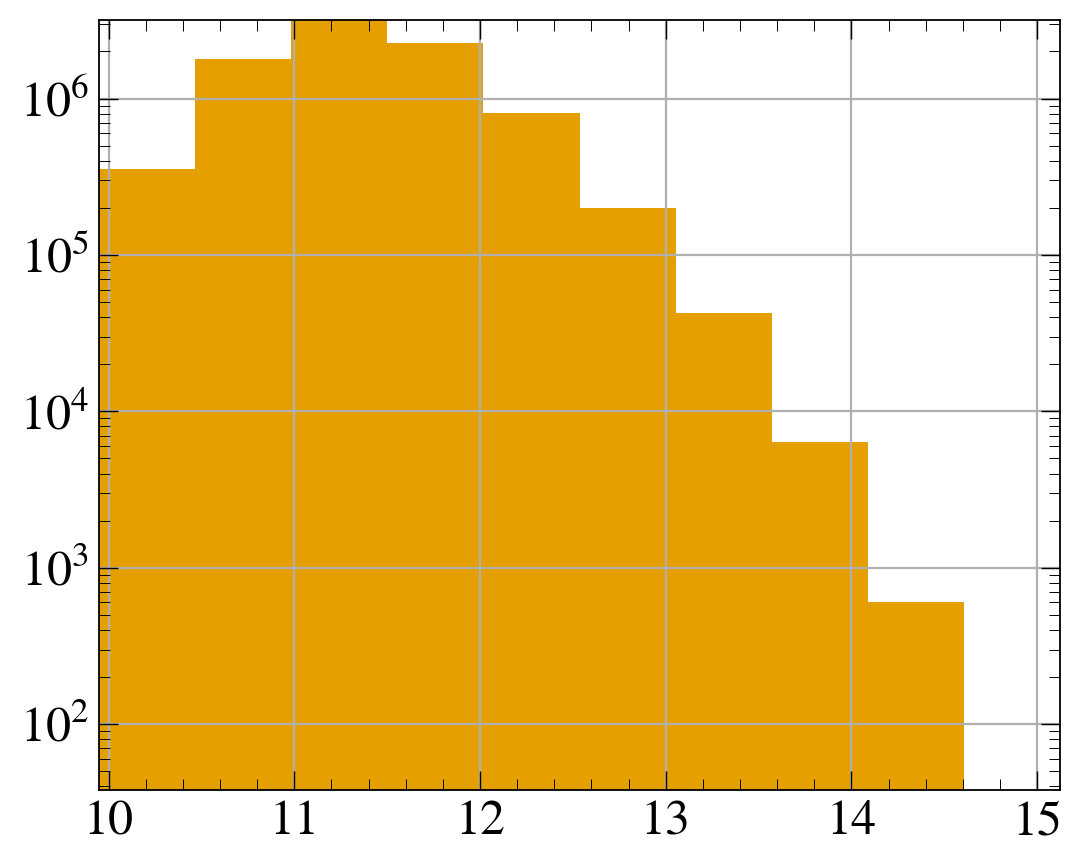

In [11]:
dc2_halo_unique['log_mass'].hist(log=True)

In [12]:
mass_bin_edges = [0,11,12,13,25]
dc2_halo_unique['mass_bin'], mass_bins =pd.cut(dc2_halo_unique['log_mass'],mass_bin_edges,retbins=True)

In [13]:
dc2_halo_unique.groupby('mass_bin').count()

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass,log_mass
mass_bin,,,,,,,,,,,,,,,,,,,,
"(0, 11]",2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892
"(11, 12]",5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595
"(12, 13]",1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704
"(13, 25]",59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515


In [14]:
dc2_halo_unique.groupby('mass_bin').mean()

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass,log_mass
mass_bin,,,,,,,,,,,,,,,,,,,,
"(0, 11]",65.362122,-39.536053,25.844603,25.300138,24.933275,24.719490,0.485535,0.514465,0.0,-90.007721,-90.007721,0.229837,0.145732,0.108154,0.098672,0.815144,6.070877e+10,-2.458474e+12,1.983009e+08,10.732269
"(11, 12]",65.364158,-39.547480,25.147860,24.783285,24.415848,24.130091,0.493830,0.506170,0.0,-90.035156,-90.035156,0.317693,0.201431,0.164159,0.141182,1.277220,3.416144e+11,1.225676e+12,3.712440e+09,11.446449
"(12, 13]",65.361471,-39.553892,24.554909,24.153942,23.767675,23.446053,0.787760,0.212240,0.0,-89.991409,-89.991409,0.488213,0.309522,0.296028,0.249081,1.446130,2.397942e+12,2.212075e+12,3.338014e+10,12.301331
"(13, 25]",65.372793,-39.552076,24.860922,24.194832,23.616198,23.208843,0.701785,0.298215,0.0,-90.216789,-90.216789,0.521712,0.330364,0.321307,0.271259,1.192978,2.346549e+13,1.933989e+12,4.508172e+10,13.270767


In [15]:
dc2_halo_unique.groupby('mass_bin').count()

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass,log_mass
mass_bin,,,,,,,,,,,,,,,,,,,,
"(0, 11]",2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892,2223892
"(11, 12]",5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595,5303595
"(12, 13]",1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704,1050704
"(13, 25]",59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515,59515


In [16]:
Nhalos_in_bin = 50000
dc2_halo_unique_subsampled = dc2_halo_unique.groupby('mass_bin').sample(Nhalos_in_bin,random_state=1)

In [17]:
dc2_halo_unique_subsampled.groupby('mass_bin').count()

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass,log_mass
mass_bin,,,,,,,,,,,,,,,,,,,,
"(0, 11]",50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
"(11, 12]",50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
"(12, 13]",50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
"(13, 25]",50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000


In [18]:
dc2_halo_unique_subsampled.groupby('mass_bin').mean()

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass,log_mass
mass_bin,,,,,,,,,,,,,,,,,,,,
"(0, 11]",65.381459,-39.540073,25.852530,25.307590,24.942068,24.726053,0.485199,0.514801,0.0,-90.444649,-90.444649,0.229254,0.145418,0.107872,0.098443,0.817235,6.064957e+10,-2.477427e+12,1.981391e+08,10.731691
"(11, 12]",65.363341,-39.529342,25.148113,24.780291,24.410843,24.123695,0.493038,0.506962,0.0,-90.108032,-90.108032,0.319302,0.203404,0.164913,0.142112,1.273798,3.417478e+11,1.191216e+12,3.718686e+09,11.446076
"(12, 13]",65.373659,-39.560378,24.556166,24.155106,23.769119,23.447701,0.787590,0.212410,0.0,-89.829559,-89.829559,0.487211,0.308321,0.295674,0.248772,1.447041,2.393157e+12,2.198815e+12,3.333985e+10,12.300644
"(13, 25]",65.378611,-39.553784,24.861160,24.194887,23.614918,23.207067,0.701170,0.298830,0.0,-90.078148,-90.078148,0.522685,0.331115,0.321948,0.271878,1.192130,2.350904e+13,1.932838e+12,4.514229e+10,13.271287


Int64Index([9687500004, 9687500006, 9687500077, 9687500089, 9687500093,
            9687500426, 9687500563, 9687500590, 9687500751, 9687501018,
            ...
            8957660268, 8957662978, 8957664843, 8957664844, 8957667641,
            8957669860, 8957671451, 8957671452, 8957672566, 8957676023],
           dtype='int64', name='galtileid', length=634065)

In [22]:
dc2_df_subsampled = dc2_df[dc2_df['halo_id'].isin(dc2_halo_unique_subsampled['halo_id'])]

In [29]:
dc2_df_subsampled

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass,log_mass
galtileid,,,,,,,,,,,,,,,,,,,,
9687500004,61.869596,-40.907121,14.888106,14.139737,13.786592,13.539910,0.992869,0.007131,0.0,-94.425529,-94.425529,13.089191,5.745582,6.417689,5.544625,0.021334,1.206931e+13,400155487,2.895573e+10,13.081683
9687500006,61.752070,-40.920467,20.176435,19.705341,19.467945,19.363020,0.473895,0.526105,0.0,-112.666656,-112.666656,2.395142,1.823457,1.072245,1.015367,0.018951,1.206931e+13,400155487,1.594001e+07,13.081683
9687500077,61.602109,-40.158534,15.049003,14.536696,14.203719,13.929540,0.683091,0.316909,0.0,-66.207359,-66.207359,14.008840,13.448575,10.033951,9.891587,0.044270,2.790155e+12,600155475,1.298029e+11,12.445628
9687500089,61.563942,-40.142509,19.258326,18.621061,18.327494,18.182968,0.159222,0.840778,0.0,-99.642601,-99.642601,1.141292,0.779305,0.629889,0.570911,0.044722,2.004116e+11,1800155475,6.522099e+08,11.301923
9687500093,61.242677,-40.040173,21.198835,20.688829,20.429756,20.310623,0.496790,0.503210,0.0,-1.178893,-1.178893,3.202859,2.226471,1.168153,1.151010,0.026818,5.465768e+10,2100155475,8.996860e+06,10.737651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8957669860,65.471006,-38.229522,26.523321,25.817144,25.748289,25.876873,0.585761,0.414239,0.0,-34.187843,-34.187843,0.337973,0.157151,0.215209,0.181853,3.039532,2.293021e+12,5367200143121,2.196984e+10,12.360408
8957671451,65.627628,-38.545471,25.124561,24.841473,24.915699,25.098455,0.895839,0.104161,0.0,-130.874725,-130.874725,0.246556,0.104097,0.170030,0.115582,2.954431,1.696981e+12,5500500143121,1.604073e+10,12.229677
8957671452,65.628275,-38.545006,25.308268,25.233334,25.282591,25.362284,0.999923,0.000077,0.0,-8.493876,-8.493876,0.126423,0.061037,0.071804,0.045215,2.955377,1.696981e+12,5500500143121,1.021448e+09,12.229677


In [43]:
mass_bins = dc2_halo_unique_subsampled.set_index('halo_id').loc[dc2_df_subsampled['halo_id']]['mass_bin'].values
dc2_df_subsampled['mass_bin']=mass_bins

/tmp/ipykernel_211707/1944862431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc2_df_subsampled['mass_bin']=mass_bins


In [39]:
dc2_df_subsampled

,ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,...,a_d,b_d,a_b,b_b,redshift,halo_mass,halo_id,stellar_mass,log_mass,mass_bin
galtileid,,,,,,,,,,,,,,,,,,,,,
9687500004,61.869596,-40.907121,14.888106,14.139737,13.786592,13.539910,0.992869,0.007131,0.0,-94.425529,...,13.089191,5.745582,6.417689,5.544625,0.021334,1.206931e+13,400155487,2.895573e+10,13.081683,"(13, 25]"
9687500006,61.752070,-40.920467,20.176435,19.705341,19.467945,19.363020,0.473895,0.526105,0.0,-112.666656,...,2.395142,1.823457,1.072245,1.015367,0.018951,1.206931e+13,400155487,1.594001e+07,13.081683,"(13, 25]"
9687500077,61.602109,-40.158534,15.049003,14.536696,14.203719,13.929540,0.683091,0.316909,0.0,-66.207359,...,14.008840,13.448575,10.033951,9.891587,0.044270,2.790155e+12,600155475,1.298029e+11,12.445628,"(12, 13]"
9687500089,61.563942,-40.142509,19.258326,18.621061,18.327494,18.182968,0.159222,0.840778,0.0,-99.642601,...,1.141292,0.779305,0.629889,0.570911,0.044722,2.004116e+11,1800155475,6.522099e+08,11.301923,"(11, 12]"
9687500093,61.242677,-40.040173,21.198835,20.688829,20.429756,20.310623,0.496790,0.503210,0.0,-1.178893,...,3.202859,2.226471,1.168153,1.151010,0.026818,5.465768e+10,2100155475,8.996860e+06,10.737651,"(0, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8957669860,65.471006,-38.229522,26.523321,25.817144,25.748289,25.876873,0.585761,0.414239,0.0,-34.187843,...,0.337973,0.157151,0.215209,0.181853,3.039532,2.293021e+12,5367200143121,2.196984e+10,12.360408,"(12, 13]"
8957671451,65.627628,-38.545471,25.124561,24.841473,24.915699,25.098455,0.895839,0.104161,0.0,-130.874725,...,0.246556,0.104097,0.170030,0.115582,2.954431,1.696981e+12,5500500143121,1.604073e+10,12.229677,"(12, 13]"
8957671452,65.628275,-38.545006,25.308268,25.233334,25.282591,25.362284,0.999923,0.000077,0.0,-8.493876,...,0.126423,0.061037,0.071804,0.045215,2.955377,1.696981e+12,5500500143121,1.021448e+09,12.229677,"(12, 13]"


In [44]:
Table.from_pandas(dc2_df_subsampled.drop("mass_bin",axis=1),index=True).write("../data/table_for_wld.fits",overwrite=True)

In [53]:
dc2_df_subsampled.to_pickle("../data/dc2_sub.pkl")

In [45]:
data = init_wldeblend(survey_bands='lsst-i')

In [46]:
print(len(data.cat),type(data.cat))

634065 <class 'numpy.ndarray'>


In [74]:
gal_list = {}

i=0
for index, gal in tqdm(dc2_df_subsampled.iterrows()):
    wl_gal = get_gal_wldeblend(rng=np.random.RandomState(1234),ind=i,data=data)
    with open("../data/gals/gals_{}.pkl".format(gal.name),"wb") as f:
        pickle.dump(wl_gal,f)
    i+=1

634065it [32:56, 320.83it/s]


In [48]:
with open("../data/gal_dict.pkl","wb") as f:
    pickle.dump(gal_list,f)

In [ ]:
for i, mass_table in enumerate(subsampled_gal):
    mass_table = Table.from_pandas(mass_table)
    gal_list = []
    for j in trange(len(mass_table)):
        gal = get_gal_wldeblend(rng=np.random.RandomState(1234), ind=i, data=data)
        id = mass_table[j]['galtileid']
        gal_list.append((gal,id))
    with open('../data/gal_list_{}.pkl'.format(i),'wb') as f:
        pickle.dump(gal_list,f)
    

100%|██████████| 214214/214214 [01:29<00:00, 2406.64it/s]


In [ ]:
dc2_subsampled = pd.concat(subsampled_gal)
dc2_subsampled = astropy.table.Table.from_pandas(dc2_subsampled)

In [ ]:
mean_mass_list = []
result_table_combined = dc2_subsampled
for n_bin in np.unique(result_table_combined['mass_bin']):
    mean_mass_list.append(np.mean(result_table_combined['halo_mass'][result_table_combined['mass_bin'] == n_bin]))

In [ ]:
mean_mass_list

[25478443438.822803, 781882473851.993, 12973954634595.172, 157800510475466.47]

In [ ]:
data.noise

420.9240990481278

In [ ]:
len(dc2_subsampled)

856856

In [ ]:
#save table
dc2_subsampled.write('../data/dc2_subsampled.fits',overwrite=True)

In [ ]:
dc2 = Table(fits.open('../data/dc2_subsampled.fits')[1].data)
print(len(dc2))

856856


In [ ]:
gal_list = []
for i in trange(len(dc2_subsampled)):
    gal = get_gal_wldeblend(rng=np.random.RandomState(1234), ind=i, data=data)
    id = dc2_subsampled[i]['galtileid']
    gal_list.append((gal,id))

 50%|████▉     | 426312/856856 [03:04<03:06, 2309.39it/s]


IndexError: index 426312 is out of bounds for axis 0 with size 426312

In [ ]:
with open('../data/gal_list.pkl','wb') as f:
    pickle.dump(gal_list,f)

In [ ]:
gal = gal_list[0][0].band_galaxies[0].withGSParams(maximum_fft_size=16000)
print(gal)

(galsim.Exponential(scale_radius=0.14765484283171085, flux=38459.83229483947).shear(galsim.Shear(g1=0.0009038525280254034,g2=0.024866338373342154)) + galsim.DeVaucouleurs(half_light_radius=0.1534247255446093, flux=29544.183401007616).shear(galsim.Shear(g1=0.00036912025077793663,g2=0.010155051594920408))).rotate(1.203352196659766 radians)


In [ ]:
import matplotlib.pyplot as plt
import galsim


def plot_gal(i):
    gal = (gal_list[i][0].band_galaxies[0].withGSParams(maximum_fft_size=16000).drawImage(scale=0.2, nx=53,ny=53).array)
    print(gal_list[i][1])
    print(gal.flatten().min())
    plt.imshow(np.log10(gal))
    plt.show()

In [ ]:
gal

galsim.Transformation(galsim.Sum([galsim.Transformation(galsim.Exponential(scale_radius=0.14765484283171085, flux=38459.83229483947, gsparams=galsim.GSParams(128,16000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.0012138521657397, 0.024874039968123256], [0.024874039968123256, 0.999405587227827]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,16000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True), galsim.Transformation(galsim.DeVaucouleurs(scale_radius=4.4349007117131576e-05, trunc=0.0, flux=29544.183401007616, gsparams=galsim.GSParams(128,16000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.000420773970436, 0.01015557594755943], [0.01015557594755943, 0.9996824953500827]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,16000,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)], gsparams=g

In [ ]:
gal.drawImage(scale=0.2, nx=53,ny=53).array

array([[0.00796689, 0.00881199, 0.00962047, ..., 0.01034651, 0.00942869,
        0.00851573],
       [0.00877513, 0.00970743, 0.01065347, ..., 0.01148586, 0.01038305,
        0.0093423 ],
       [0.00964662, 0.01065452, 0.011771  , ..., 0.01266357, 0.01144331,
        0.01028989],
       ...,
       [0.01028989, 0.01144331, 0.01266357, ..., 0.011771  , 0.01065452,
        0.00964662],
       [0.0093423 , 0.01038305, 0.01148586, ..., 0.01065347, 0.00970743,
        0.00877513],
       [0.00851573, 0.00942869, 0.01034651, ..., 0.00962047, 0.00881199,
        0.00796689]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
import galsim


def plot_gal(i):
    gal = (gal_list[i][0].band_galaxies[0].withGSParams(maximum_fft_size=160000).drawImage(scale=0.2, nx=53,ny=53).array)
    print(gal_list[i][1])
    print(gal.flatten().min())
    plt.imshow(np.log10(gal))
    plt.show()

7937801974
0.105793014


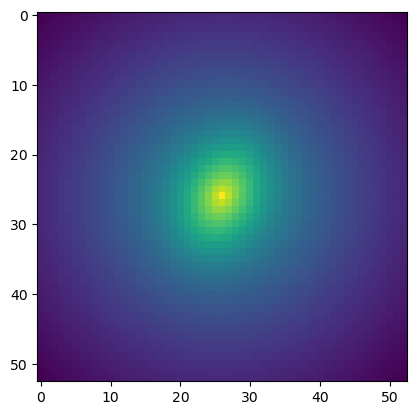

In [ ]:
plot_gal(14)
gal = gal_list[14]

(array([2.798e+03, 6.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.05793014e-01, 7.74983740e+03, 1.54995693e+04, 2.32493008e+04,
        3.09990312e+04, 3.87487656e+04, 4.64984961e+04, 5.42482266e+04,
        6.19979570e+04, 6.97476875e+04, 7.74974219e+04]),
 <BarContainer object of 10 artists>)

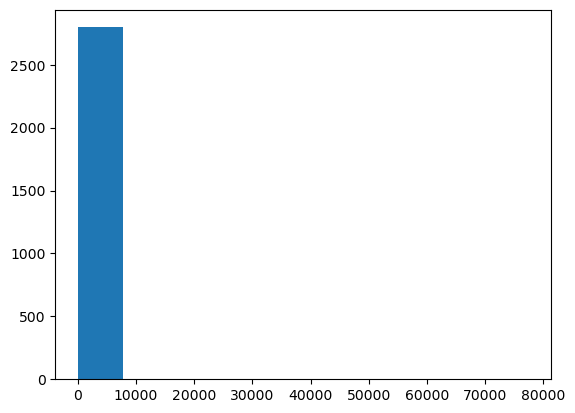

In [ ]:
number = gal[0].band_galaxies[0].drawImage(scale=0.2, nx=53,ny=53).array
plt.hist(number.flatten())

10631428896
0.007966888


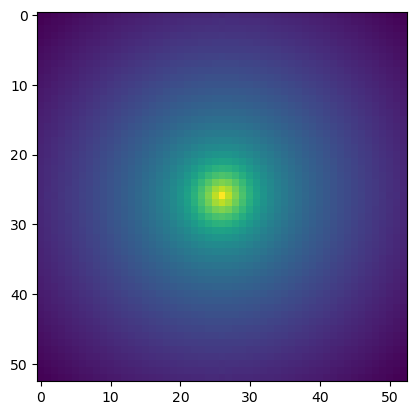

9754008299
0.026255025


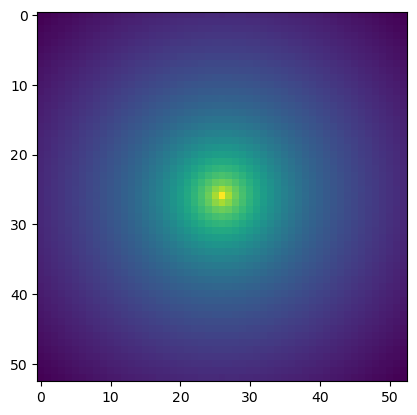

7065013476
3.754609e-05


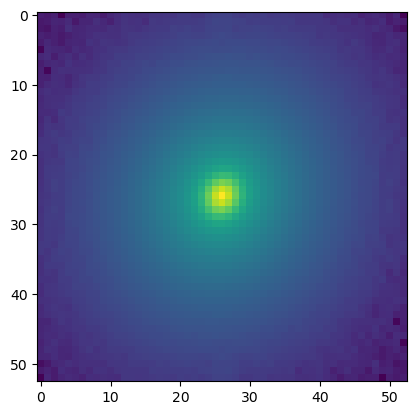

9750436613
0.00023420254


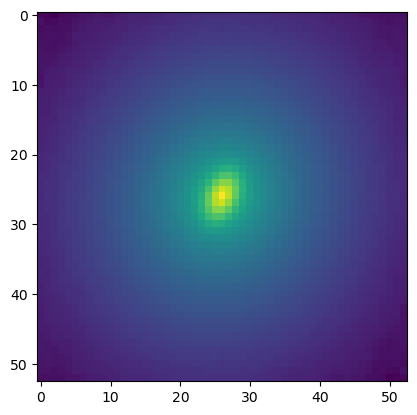

11327942208
0.00029346434


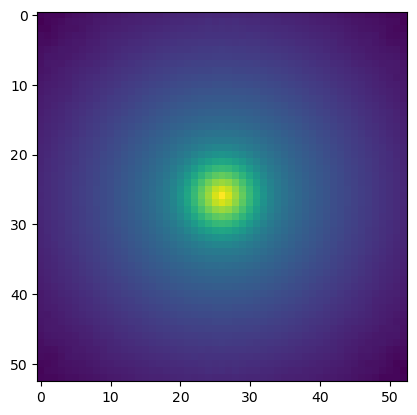

11312748314
0.03088215


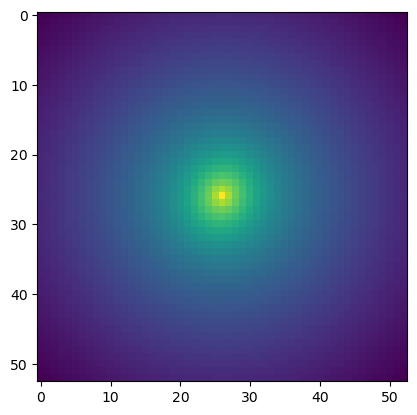

7001690587
0.002634879


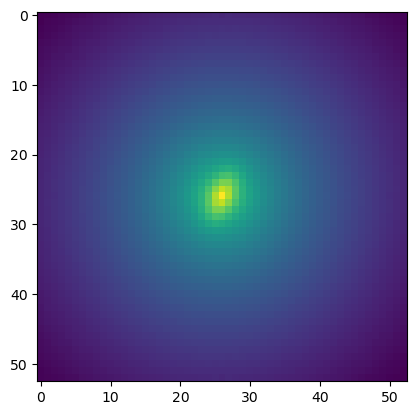

11939416952
0.0008078419


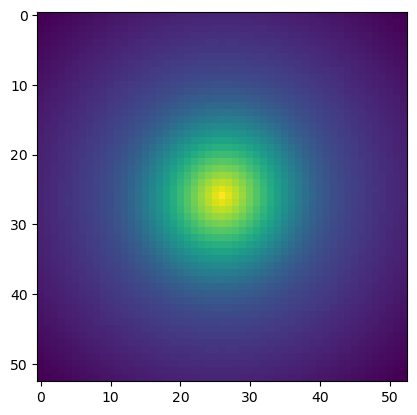

11937526023
7.483862e-05


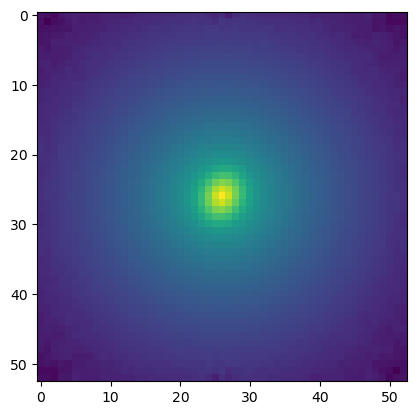

8937524830
0.0005789213


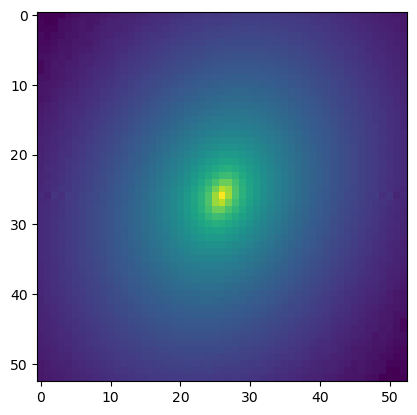

7065035668
-0.0015137043


/tmp/ipykernel_141970/4016499379.py:9: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


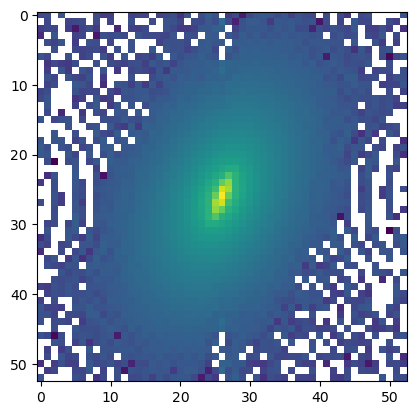

11250887197
-0.0017567489


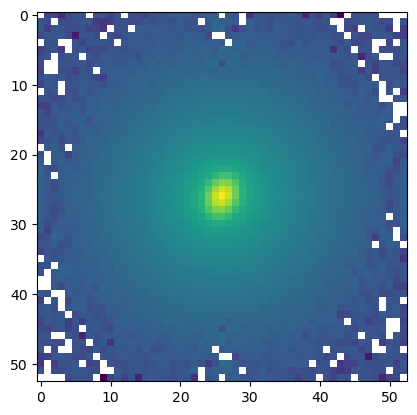

9688374961
0.006941454


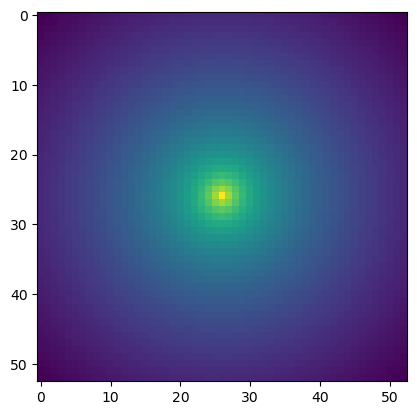

7001416953
0.00012831124


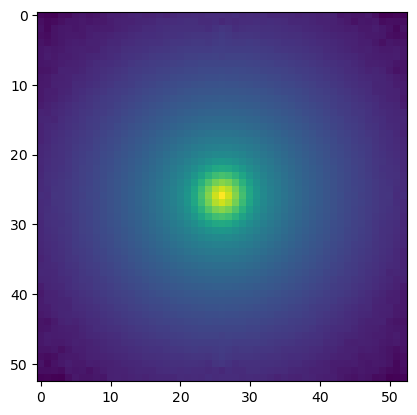

7937801974
0.105793014


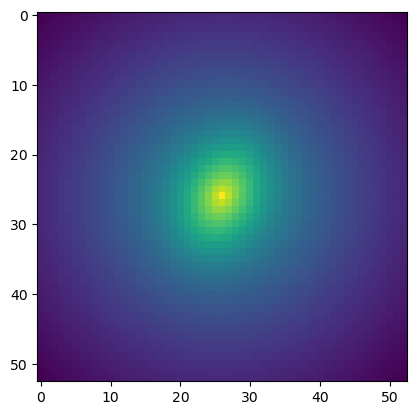

KeyboardInterrupt: 

In [ ]:
for i in range(426300):
    plot_gal(i)

10500450829
-5.3813616e-05


/tmp/ipykernel_29235/1815656971.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


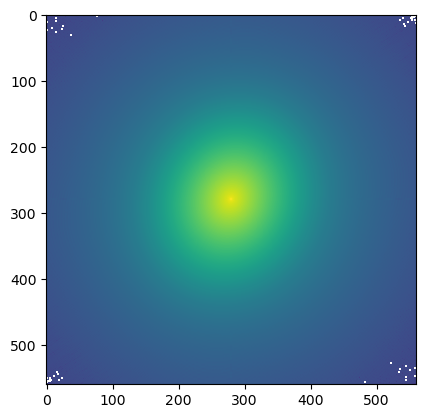

In [ ]:
plot_gal(4)

In [ ]:
dc2[dc2['galtileid'] == 10500450829]

ra,dec,g_ab,r_ab,i_ab,z_ab,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,pa_disk,pa_bulge,a_d,b_d,a_b,b_b,redshift,galtileid,halo_mass,mass_bin
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,float64,int64
63.09045973838988,-42.32085239893416,27.039055,25.918615,25.56965,25.456654,0.37293038,0.6270696,0.0,-22.987753,-22.987753,0.20719016,0.1159799,0.09284142,0.091700174,0.51056283955128,10500450829,71901483336.5934,1


-0.0010072638


/tmp/ipykernel_29235/635352088.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


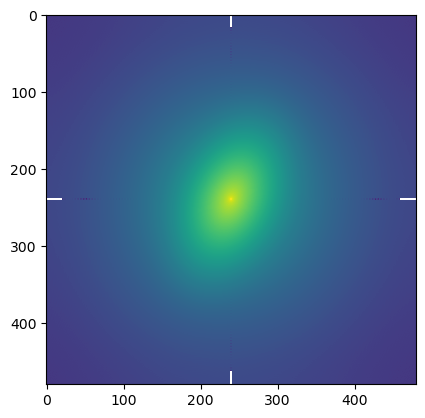

In [ ]:
plot_gal(24)

-0.0051063183


/tmp/ipykernel_29235/635352088.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


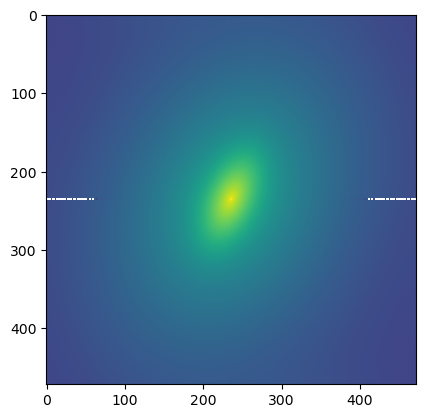

In [ ]:
plot_gal(34)

-0.006585863


/tmp/ipykernel_29235/635352088.py:5: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(gal))


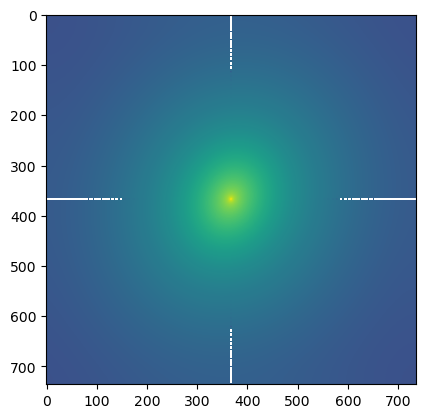

In [ ]:
plot_gal(40)